# Data Clearning and Reconstruction

In [4]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# data preprocessing
import os

'''
We are training the model based on the overhead images inside of side-angle videos which are more complex and low quality.
Since the original dataset provides the split of the training/testing set based on the images (side-angle videos and overhead), we need to find all dish ids that are present in the overhead images.
Therefore, we first find the ids in the training/testing set and then find the intersection of these ids with the overhead images.

'''

nutrition5k_path = '../data/nutrition5k'
nutrition5k_overhead_path = os.path.join(nutrition5k_path, 'realsense_overhead')
train_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_train_ids.txt')
test_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_test_ids.txt')
original_labels = os.path.join(nutrition5k_path, 'metadata/dish_metadata_cafe1.csv')

"""
realsense_overhead
    - image_index
        - depth_color.png
        - depth_raw.png
        - rgb.png
        
        
side_angles
    - image_index
        - frames_sampled30
            - camera_{}_frame_{}.png
            
metadata
    - dish_metadata_cafe1.csv
        - dish_id, dish_name, calories, mass, fat, carb, protein, ingredients content
    - dish_metadata_cafe2.csv
    - ingredients_metadata.csv
"""

overhead_ids = set()
for file in os.listdir(nutrition5k_overhead_path):
    overhead_ids.add(file)
    
print('Number of unique overhead ids: ', len(overhead_ids))

train_dis = set()
test_dis = set()
with open(train_dir, 'r') as f:
    train_list = f.readlines()
    for i in train_list:
        train_dis.add(i.strip())
        
with open(test_dir, 'r') as f:
    test_list = f.readlines()
    for i in test_list:
        test_dis.add(i.strip())

print('Valid Training Samples:', len(train_dis.intersection(overhead_ids)))
print('Intersection (Test and Overhead):', len(test_dis.intersection(overhead_ids)))

valid_overhead_ids = train_dis.intersection(overhead_ids).union(test_dis.intersection(overhead_ids))
print('Number of valid overhead ids:', len(valid_overhead_ids))

labels_dict = {}
with open(original_labels, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip().split(',')
        if line[0] in valid_overhead_ids:
            labels_dict[line[0]] = line[1:]

print('Number of valid overhead ids with labels:', len(labels_dict))
## Example of labels_dict
print('Example of labels_dict:', labels_dict['dish_1566851198'])

Number of unique overhead ids:  3490
Valid Training Samples: 2755
Intersection (Test and Overhead): 507
Number of valid overhead ids: 3262
Number of valid overhead ids with labels: 3262
Example of labels_dict: ['463.047455', '342.000000', '21.119635', '42.903687', '25.897209', 'ingr_0000000377', 'quinoa', '161.874344', '194.2492128', '3.075612536', '33.99361224', '7.122471136', 'ingr_0000000189', 'vinegar', '3.363364', '0.0', '0.0', '0.0', '0.0', 'ingr_0000000152', 'cabbage', '7.961165', '1.67184465', '0.039805825', '0.25475728', '0.103495145', 'ingr_0000000133', 'shallots', '0.809372', '0.1618744', '0.001618744', '0.026709276', '0.01214058', 'ingr_0000000094', 'onions', '5.045045', '2.018018', '0.005045045', '0.45405405', '0.055495495', 'ingr_0000000126', 'mustard', '0.420420', '0.25771746', '0.01387386', '0.0252252', '0.01555554', 'ingr_0000000031', 'cucumbers', '8.408408', '0.8408408', '0.0', '0.16816816', '0.08408408', 'ingr_0000000518', 'thyme', '0.809372', '0.81746572', '0.013759

In [5]:
# Reconstruction of the dataset (Including Images and Labels)
import time

start_time = time.time()
print('Start Reconstruction...')

# create a new dataset containing only the valid overhead ids
data_path = '../data/nutrition5k_reconstructed'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
image_path = os.path.join(data_path, 'images')
if not os.path.exists(image_path):
    os.makedirs(image_path)

index = 0
for i in valid_overhead_ids:
    curr_overhead_image_path = os.path.join(nutrition5k_overhead_path, i)
        
    for overhead_pics in os.listdir(curr_overhead_image_path):
        if overhead_pics != 'rgb.png':
            continue
        # print overhead pics's absolute path
        abs_address = os.path.join(curr_overhead_image_path, overhead_pics)
        os.system('cp ' + abs_address + ' ' + os.path.join(image_path, f'{i}.jpeg'))
        index += 1
        
print('Number of images:', index)
        
# reconstruct the labels and metadata
metadata_path = os.path.join(data_path, 'metadata')
if not os.path.exists(metadata_path):
    os.makedirs(metadata_path)
    
# Reconstruct the training and testing metadata
train_ids_path = os.path.join(metadata_path, 'train_ids.csv')
test_ids_path = os.path.join(metadata_path, 'test_ids.csv')

index = 0
with open(train_ids_path, 'w') as f:
    for i in train_dis.intersection(valid_overhead_ids):
        f.write(i + '\n')
        index += 1
print('Number of training ids:', index)

index = 0
with open(test_ids_path, 'w') as f:
    for i in test_dis.intersection(valid_overhead_ids):
        f.write(i + '\n')
        index += 1
        
print('Number of testing ids:', index)

# Reconstruct the labels
labels_path = os.path.join(data_path, 'labels')
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
index = 0
labels_file = os.path.join(labels_path, 'labels.csv')
with open(labels_file, 'w') as f:
    f.write('id,calories,mass,fat,carb,protein\n')
    for ids in valid_overhead_ids:
        data = labels_dict[ids]
        # take only the first 5 columns (calories, mass, fat, carb, protein)
        f.write(ids + ',' + ','.join(data[:5]) + '\n')
        index += 1
            
print('Number of labels:', index)

end_time = time.time()
print('Data preprocessing done!')
print('Time taken to copy images: ', end_time - start_time)
print('Data stored in: ', data_path)


Start Reconstruction...
Number of images: 3262
Number of training ids: 2755
Number of testing ids: 507
Number of labels: 3262
Data preprocessing done!
Time taken to copy images:  61.92357802391052
Data stored in:  ../data/nutrition5k_reconstructed


In [10]:
# Sanity Check
df = pd.read_csv(labels_file)
print(df.head())

print()

print('Number of ids in both the training and testing set:', len(train_dis.intersection(test_dis)))

                id    calories   mass        fat       carb    protein
0  dish_1566851198  463.047455  342.0  21.119635  42.903687  25.897209
1  dish_1565119439  465.412231  189.0  19.563423  42.858475  27.351355
2  dish_1561753432  380.321686  238.0  19.463066  16.882177  33.369026
3  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593
4  dish_1563205982  316.239502  469.0   4.363000  54.792000  16.148998

Number of ids in both the training and testing set: 0


# Data Visualization

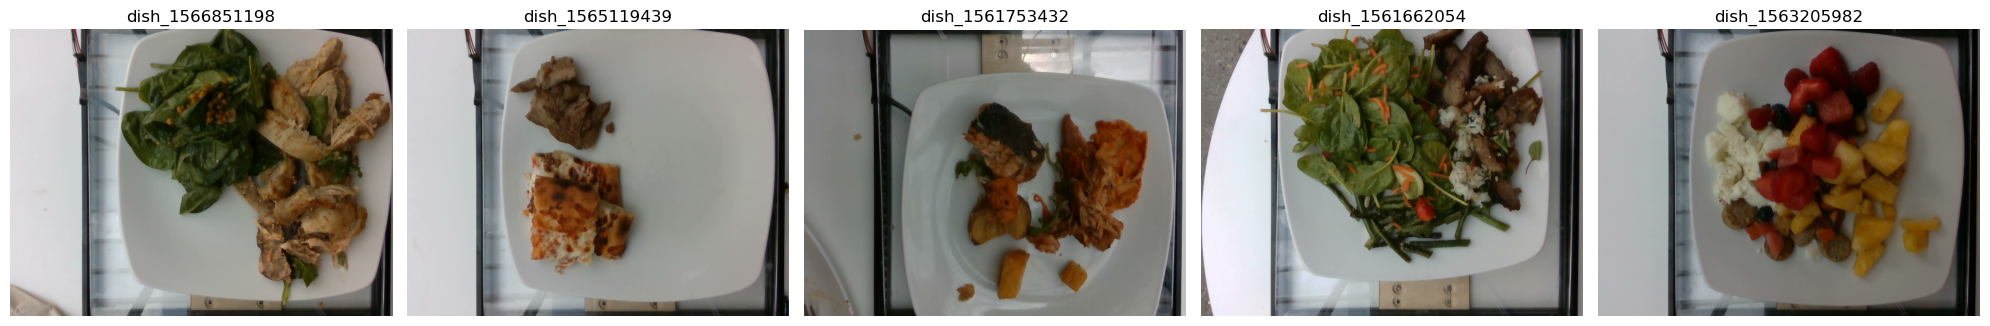

                id    calories   mass        fat       carb    protein
0  dish_1566851198  463.047455  342.0  21.119635  42.903687  25.897209
1  dish_1565119439  465.412231  189.0  19.563423  42.858475  27.351355
2  dish_1561753432  380.321686  238.0  19.463066  16.882177  33.369026
3  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593
4  dish_1563205982  316.239502  469.0   4.363000  54.792000  16.148998


In [14]:
import matplotlib.pyplot as plt
from PIL import Image


# this function will plot images in the form of a grid with 1 row and 5 columns where images are placed in the first batch
def plotImages(images_arr, ids):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    # show ids as well
    for img, ax, id in zip(images_arr, axes, ids):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(id)
    plt.tight_layout()
    plt.show()

# Displaying the first 5 images from the dataset
images = [Image.open(os.path.join(image_path, f'{i}.jpeg')) for i in df['id'][:5]]
ids = df['id'][:5]
plotImages(images, ids)

# Displaying the first 5 labels from the dataset
print(df.head())